# **Procesamiento de Lenguaje Natural**
## **Tarea 3 - Minería de Texto Básica**
## Gustavo Hernández Angeles

## **Selección de Términos y DTR**

### Punto 1
Programa y visualiza TCOR. Puede hacer esto de forma similar a como el profesor lo hizo en la *Práctica 4* con DOR. El pesado puede ser el que el profesor sugirió en clase TCOR o PPMI como lo sugiere Dan Jurafsky: hacer al menos dos gráficas; la de constelación de palabras y subconjunto para ver algunas palabras con flechas

In [48]:
import numpy as np
import nltk
from nltk.tokenize import TweetTokenizer
from pathlib import Path

#### Leer corpus

In [49]:
def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []

    # Manera más chida de abrir (y cerrar auto) archivos.
    with open(path_corpus, "r", encoding="utf-8-sig") as f_corpus, open(path_truth, "r", encoding="utf-8-sig") as f_truth:
        for twitt in f_corpus:
            tr_txt.append(twitt.strip())
        for label in f_truth:
            tr_y.append(label.strip())

    return tr_txt, tr_y

In [57]:
path_train_data = Path("./data/mex_train.txt")
path_train_labels = Path("./data/mex_train_labels.txt")
path_val_data = Path("./data/mex_val.txt")
path_val_labels = Path("./data/mex_val_labels.txt")
tr_txt, tr_y = get_texts_from_file(path_train_data, path_train_labels)
val_txt, val_y = get_texts_from_file(path_val_data, path_val_labels)

In [58]:
print(set(tr_y))
print(set(val_y))

{'1', '0'}
{'1', '0'}


In [51]:
tokenizer = TweetTokenizer()

In [52]:
corpus_palabras = []
for doc in tr_txt:
    corpus_palabras += tokenizer.tokenize(doc)
fdist = nltk.FreqDist(corpus_palabras)

Utilizamos las 5000 palabras más frecuentes.

In [53]:
def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

V = sortFreqDict(fdist)
V = V[:5000]

In [54]:
dict_indices = dict()
contador=0
for weight, word in V:
    dict_indices[word] = contador
    contador += 1

BoW para futura feature selection

In [55]:
# Definimos una BOW con esquema de peso binario.
def build_bow_tr(tr_txt, V, dict_indices):
    # Construimos en 0
    BOW = np.zeros(shape=(len(tr_txt), len(V)), dtype=int)
    
    
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        
        for word in fdist_doc:
            if word not in dict_indices:
                continue
            BOW[cont_doc, dict_indices[word]] = 1
            
        cont_doc += 1
    return BOW

#### **Calculamos TCOR**

In [37]:
# El pesado fue el sugerido en la clase de Vector Representations.
# term-term frecuency X inverse term frecuency
def compute_tcor(tr_txt, V):
    tam_V = len(V) # Tamaño de vocabulario |T_k|
    
    TCOR = np.zeros(shape=(tam_V, tam_V), dtype=float)
    print("TCOR - Tamaño de matriz:", TCOR.shape)
    
    
    ### Término log t/t_k
    cocur = {i : set() for i in range(tam_V)}
    
    # Guardamos las palabras con las que co-ocurrió la palabra 
    for doc in tr_txt:
        palabras = tokenizer.tokenize(doc)
        for word1 in palabras:
            for word2 in palabras:
                if word1 != word2 and word1 in dict_indices and word2 in dict_indices:
                    cocur[dict_indices[word1]].add(word2)
    
    # log t/t_k
    t_k = np.array([len(cocur[i]) for i in cocur])
    for indice_nonulo in np.nonzero(t_k):
        t_k[indice_nonulo] = np.log10(tam_V / t_k[indice_nonulo])
    
    ### Término 1 + log(t_i,t_k)
    
    cocur = {i : dict() for i in range(tam_V)}
    
    # Guardamos las palabras con las que co-ocurrió junto con su frecuencia
    for doc in tr_txt:
        palabras = tokenizer.tokenize(doc)
        for word1 in palabras:
            for word2 in palabras:
                if word1 != word2 and word1 in dict_indices and word2 in dict_indices:
                    cocur[dict_indices[word1]][dict_indices[word2]] = cocur[dict_indices[word1]].get(dict_indices[word2],0) + 1
    
    # Actualizamos la matriz de frecuencias termino-termino
    for indice1 in cocur:
        for indice2 in cocur[indice1]:
            TCOR[indice1,indice2] = cocur[indice1][indice2]
    
    # 1 + log(t_i, t_k)
    for i, j in zip(TCOR.nonzero()[0], TCOR.nonzero()[1]):
        TCOR[i,j] = np.log10(1 + TCOR[i,j])
        
    ### Con ayudota del broadcasting de numpy
    
    TCOR = TCOR * t_k.T # Cada renglón k se multiplica por su log(t/t_k)
            
    return TCOR

In [38]:
TCOR = compute_tcor(tr_txt, V)

TCOR - Tamaño de matriz: (5000, 5000)


#### Gráfica de constelaciones

Lo haré igual que el profesor, es decir, utilizando TSNE y algoritmos de feature-selection de Scikit-Learn.  
La única diferencia es que utilizaré las 3000 "mejores" palabras.

In [11]:
dict_indice_invertido = {}
for w in dict_indices:
    dict_indice_invertido[dict_indices[w]] = w
    
from nltk.corpus import stopwords
sw = stopwords.words("spanish")

In [12]:
from sklearn.preprocessing import normalize
TCOR_base = normalize(TCOR, norm="l2")

# feature selection
from sklearn.feature_selection import SelectKBest, chi2
feats = SelectKBest(chi2, k = 3000)
BOW = build_bow_tr(tr_txt, V, dict_indices)
feats.fit(BOW, tr_y)
best = feats.get_support(indices=True)
target_words = [dict_indice_invertido[index] for index in best]
target_matrix = np.array([TCOR_base[dict_indices[word]] for word in target_words])

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
reduced_matrix = tsne.fit_transform(target_matrix)

In [13]:
max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

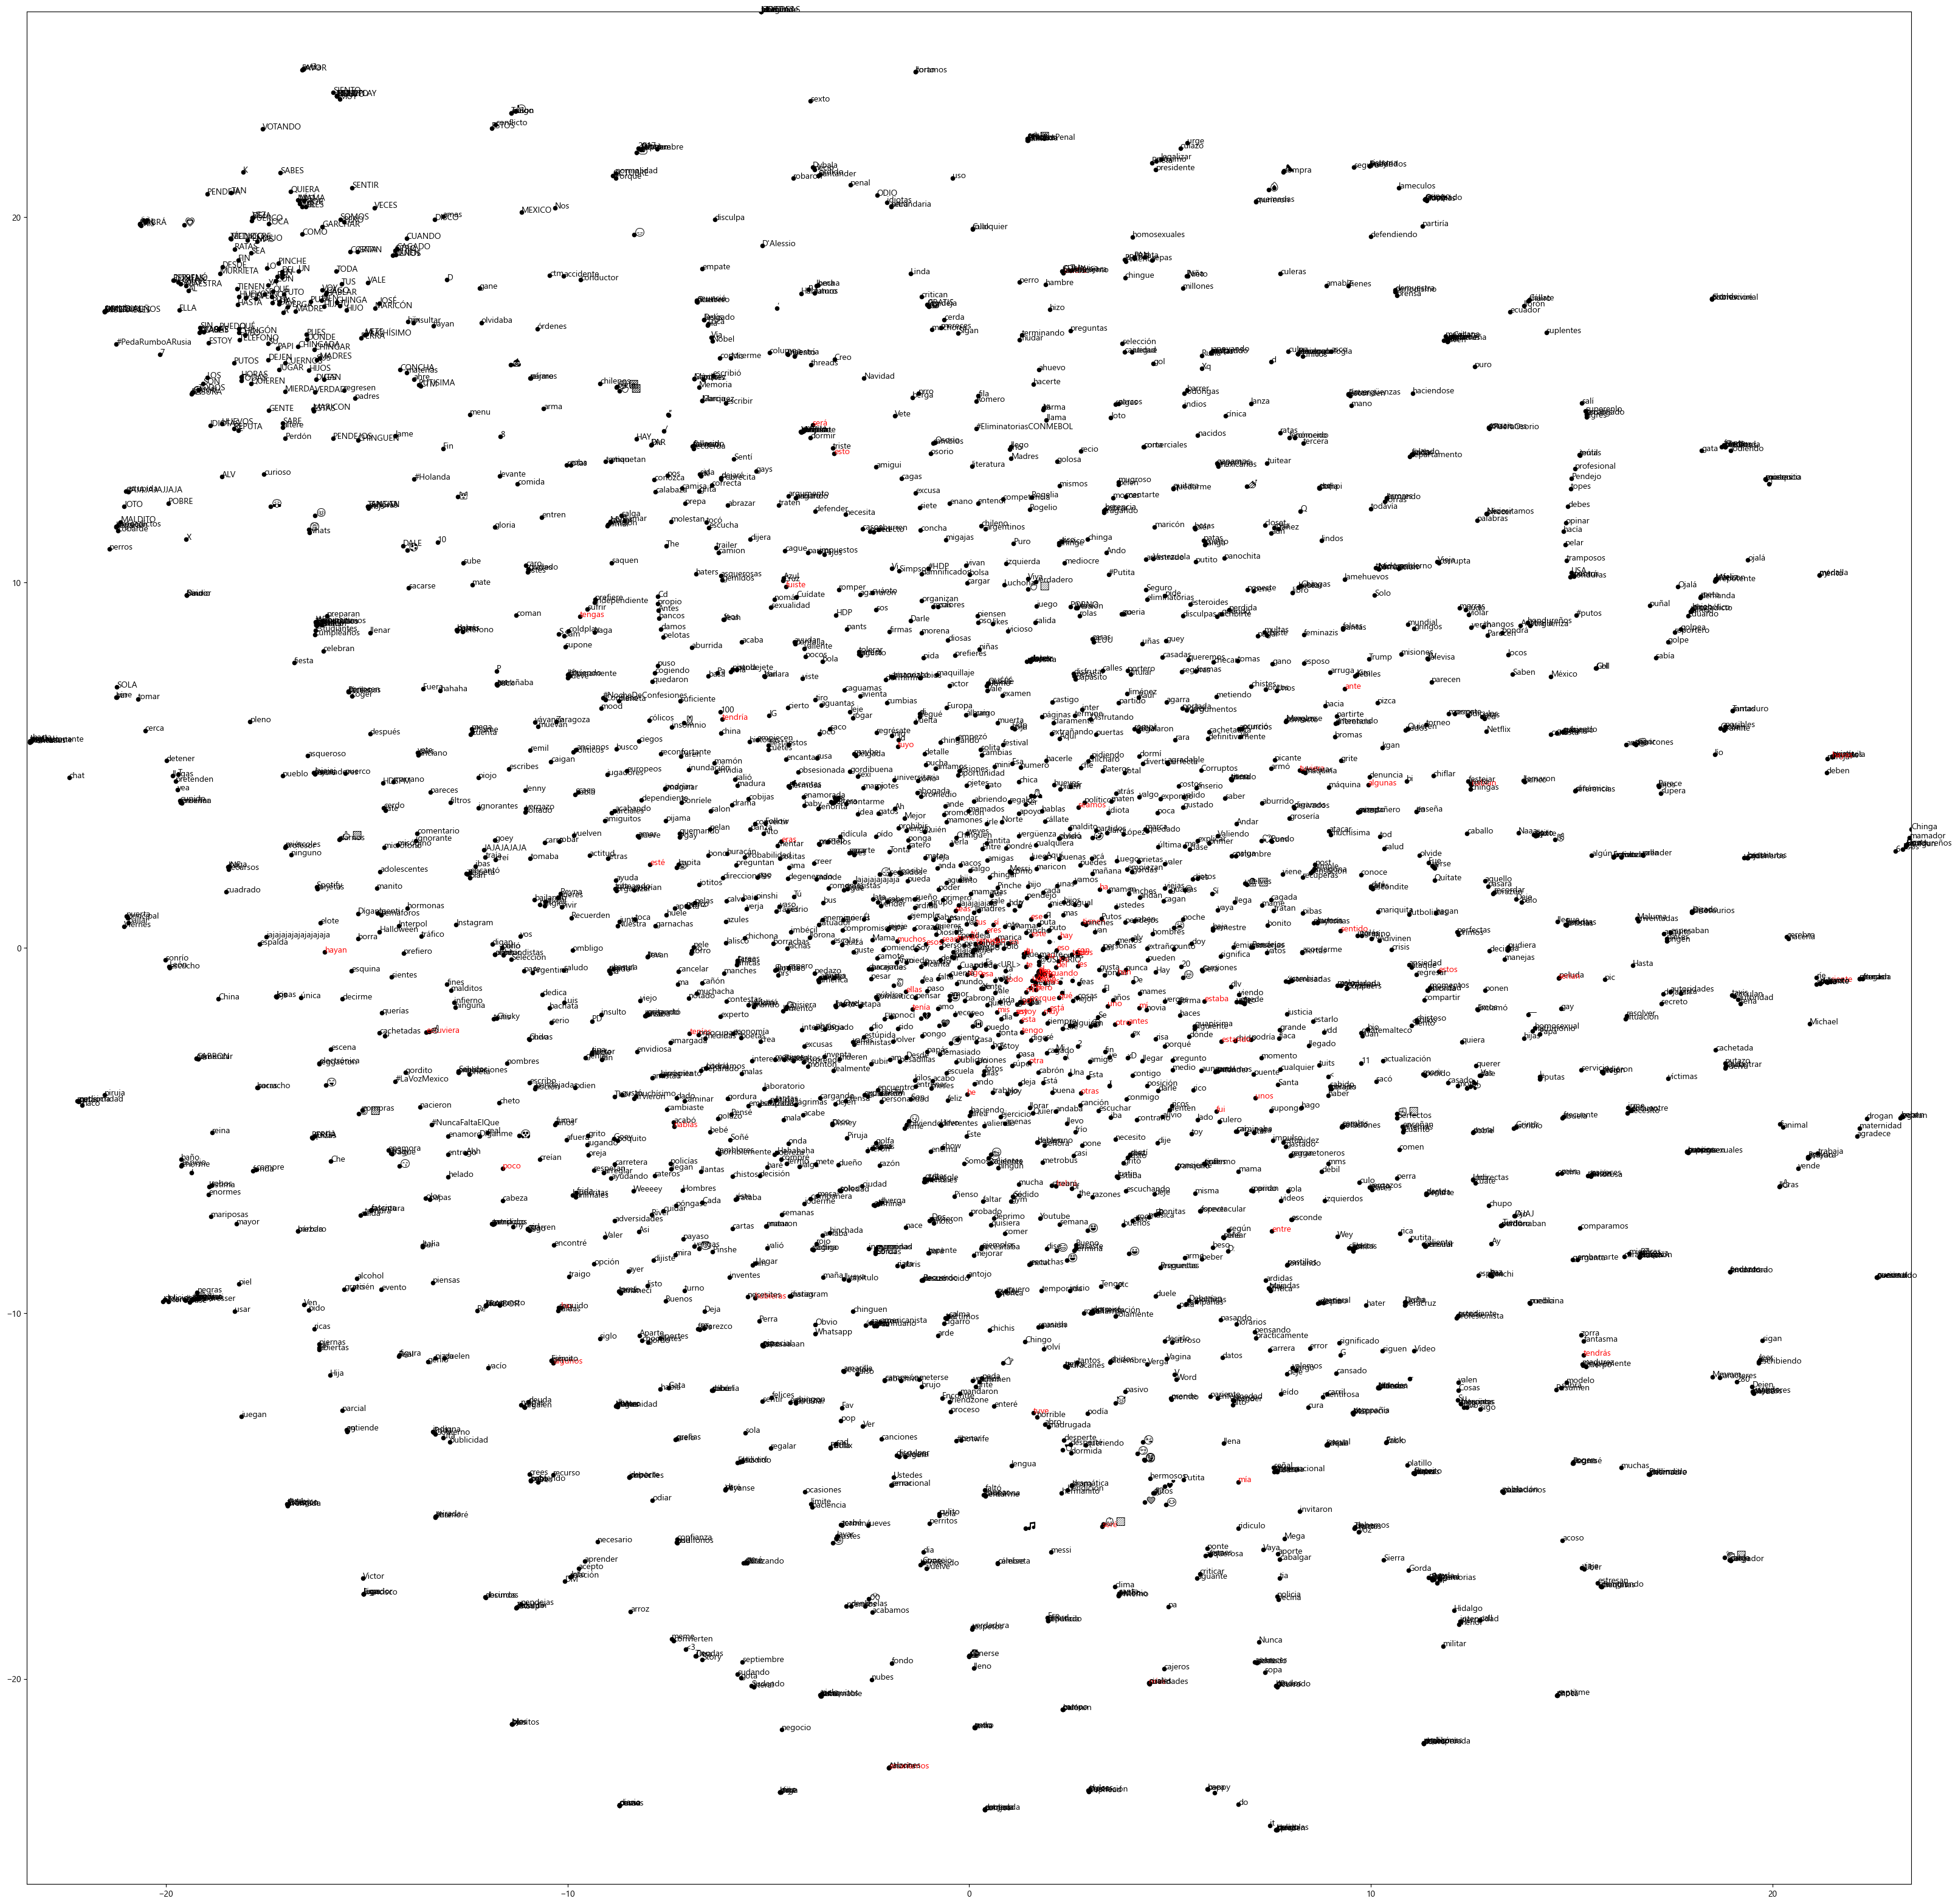

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Segoe UI Emoji'

plt.figure(figsize=(40,40), dpi = 100)
plt.xlim((-max_x,max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color = "black")

for idx, word in enumerate(target_words):
    x = reduced_matrix[idx,0]
    y = reduced_matrix[idx,1]
    
    if word in sw:
        plt.annotate(word, (x,y), color = "red")
    else:
        plt.annotate(word, (x,y), color="black")

Podemos ver que hay un cúmulo de palabras bien agrupadas en la parte superior izquierda de la gráfica. La mayoría de estas palabras están en mayúsculas y tienen una propósito de insulto y sentimientos negativos, en general.

Además, también podemos observar que la mayoría de stopwords se acumulan todas en el centro de la gráfica, quizá denotando que no tienen mucha importancia.

#### Gráfica de palabras con flechas

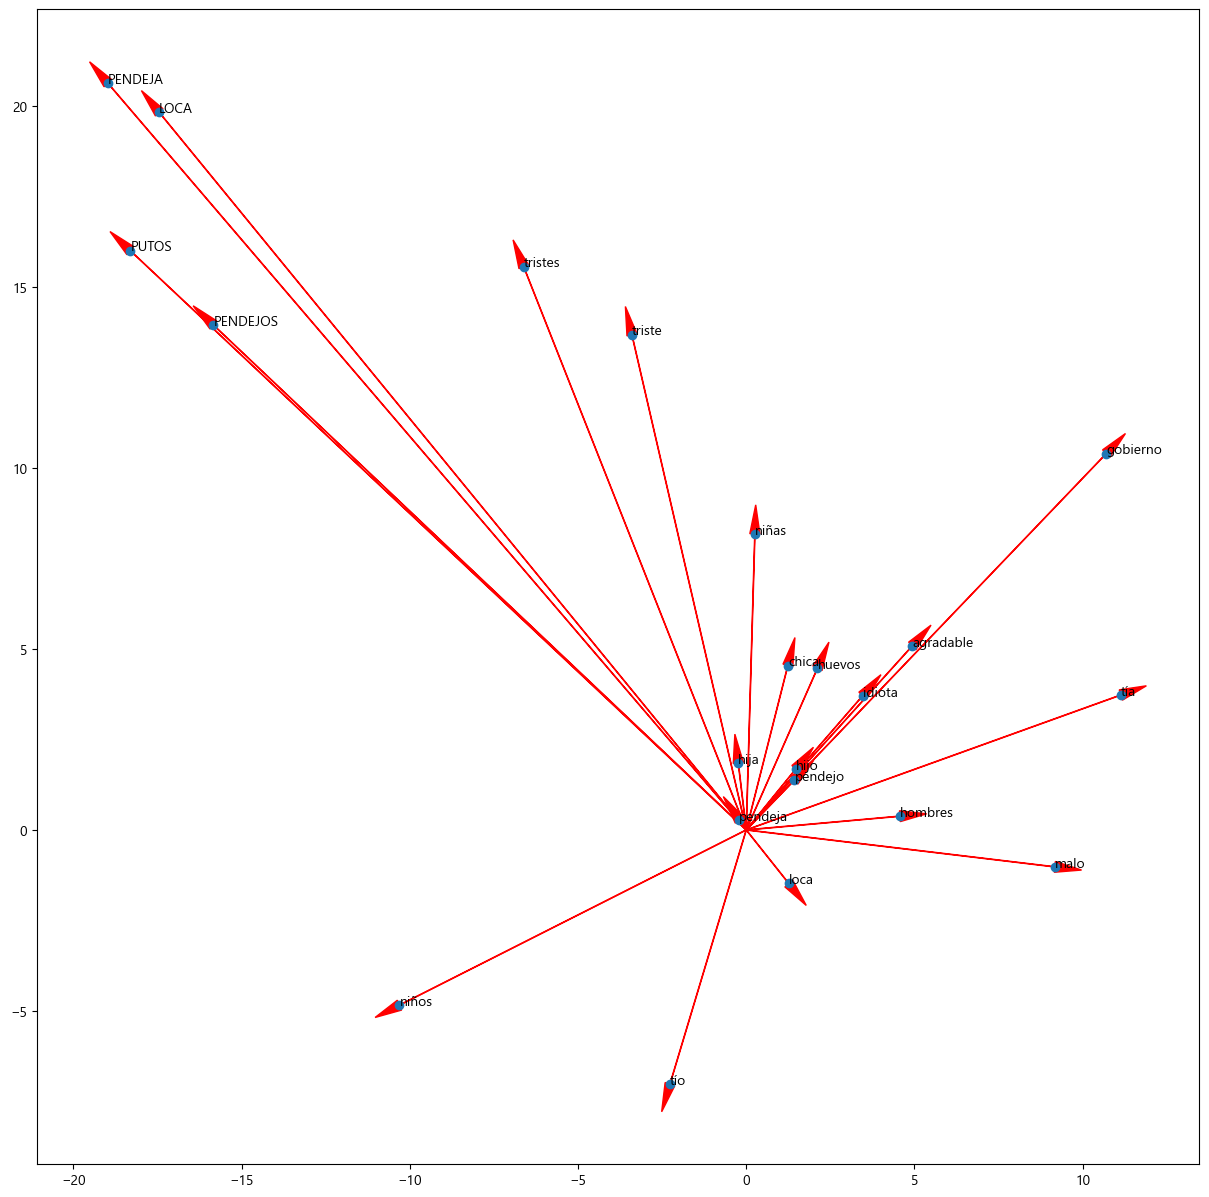

In [15]:
subset_words = ["tía", "tío", "idiota", "estúpido", "loca","tristes", "triste", "alegría", "pendejo", "pendeja", "chica", "hombres", "hija", "hijo"] +\
    ["flojo","gobierno","PUTOS", "PENDEJA", "LOCA","PENDEJOS","huevos", "bueno", "empático", "simpático", "agradable", "fútbol", "mujeres","hombres", "niños", "niñas", "malo", "horrendo", "desagradable", "psicópata", "tonto"] +\
    ["tristeza"]

plotted_subsetwords = []
subreduced_matrix = []

for idx, word in enumerate(target_words):
    if word in subset_words:
        plotted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)
fig, ax = plt.subplots(figsize=(15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0,0, word[col1], word[col2], head_width = 0.3, head_length=0.8, fc = "r", ec = "r", width = 1e-2)

ax.scatter(subreduced_matrix[:,0], subreduced_matrix[:,1])

for i in range(0, len(plotted_subsetwords)):
    ax.annotate(plotted_subsetwords[i], (subreduced_matrix[i,0], subreduced_matrix[i,1]))
    
plt.show()

Si tomamos el coseno de los ángulos entre los vectores como una medida de similaridad, podemos ver, por ejemplo, `niños` no está muy relacionado con `loca` y los insultos. También podemos confirmar que las palabras de ofensa (en mayúsculas) son muy similares, en particular, cuando están en minúsculas apuntan a una dirección contraria.

### Punto 2
Programa y visualiza alguna implementación de Random Indexing. Puedes hacer esto 
reasando parte del código del profesor en la *Práctica 4* con DOR. Hacer al menos dos 
gráficas, la de constelación de palabras y subconjunto para ver algunas palabras con 
flechas.

#### Programar Random Indexing

En este caso establecí un `ratio = 0.1` para la proporción de elementos que contendrán 1's y -1's.  
Y también establecí el parámetro `dimensiones` para el número de dimensiones del random indexing.

In [39]:
def computeRandomIndexing(tr_txt, V, dict_indices, dimensiones = 1000, ratio = 0.1):
    tam_V = len(V)
    RI = np.zeros(shape=(tam_V, dimensiones), dtype=int)
    
    ### Indexado aleatorio de documentos
    doc_ri = np.zeros(shape=(len(tr_txt), dimensiones), dtype=int)
    for i in range(len(tr_txt)):
        elementos_uno = np.random.choice(dimensiones, int(dimensiones*ratio/2), replace=False)
        elementos_menosuno = np.random.choice(dimensiones, int(dimensiones*ratio/2), replace=False)
        doc_ri[i][elementos_uno] = 1
        doc_ri[i][elementos_menosuno] = -1
    
    ### Indexado de términos
    contador = 0
    for doc in tr_txt:
        palabras = tokenizer.tokenize(doc)
        for palabra in palabras:
            if palabra in dict_indices:
                indice = dict_indices[palabra]
                RI[indice] += doc_ri[contador]
        contador += 1

    return RI

In [40]:
RI = computeRandomIndexing(tr_txt, V, dict_indices)

#### Gráfica de constelaciones

In [18]:
RI_base = normalize(RI, "l2")

target_matrix = np.array([RI_base[dict_indices[word]] for word in target_words])
reduced_matrix = tsne.fit_transform(target_matrix)

max_x = np.amax(reduced_matrix, axis = 0)[0]
max_y = np.amax(reduced_matrix, axis = 0)[1]

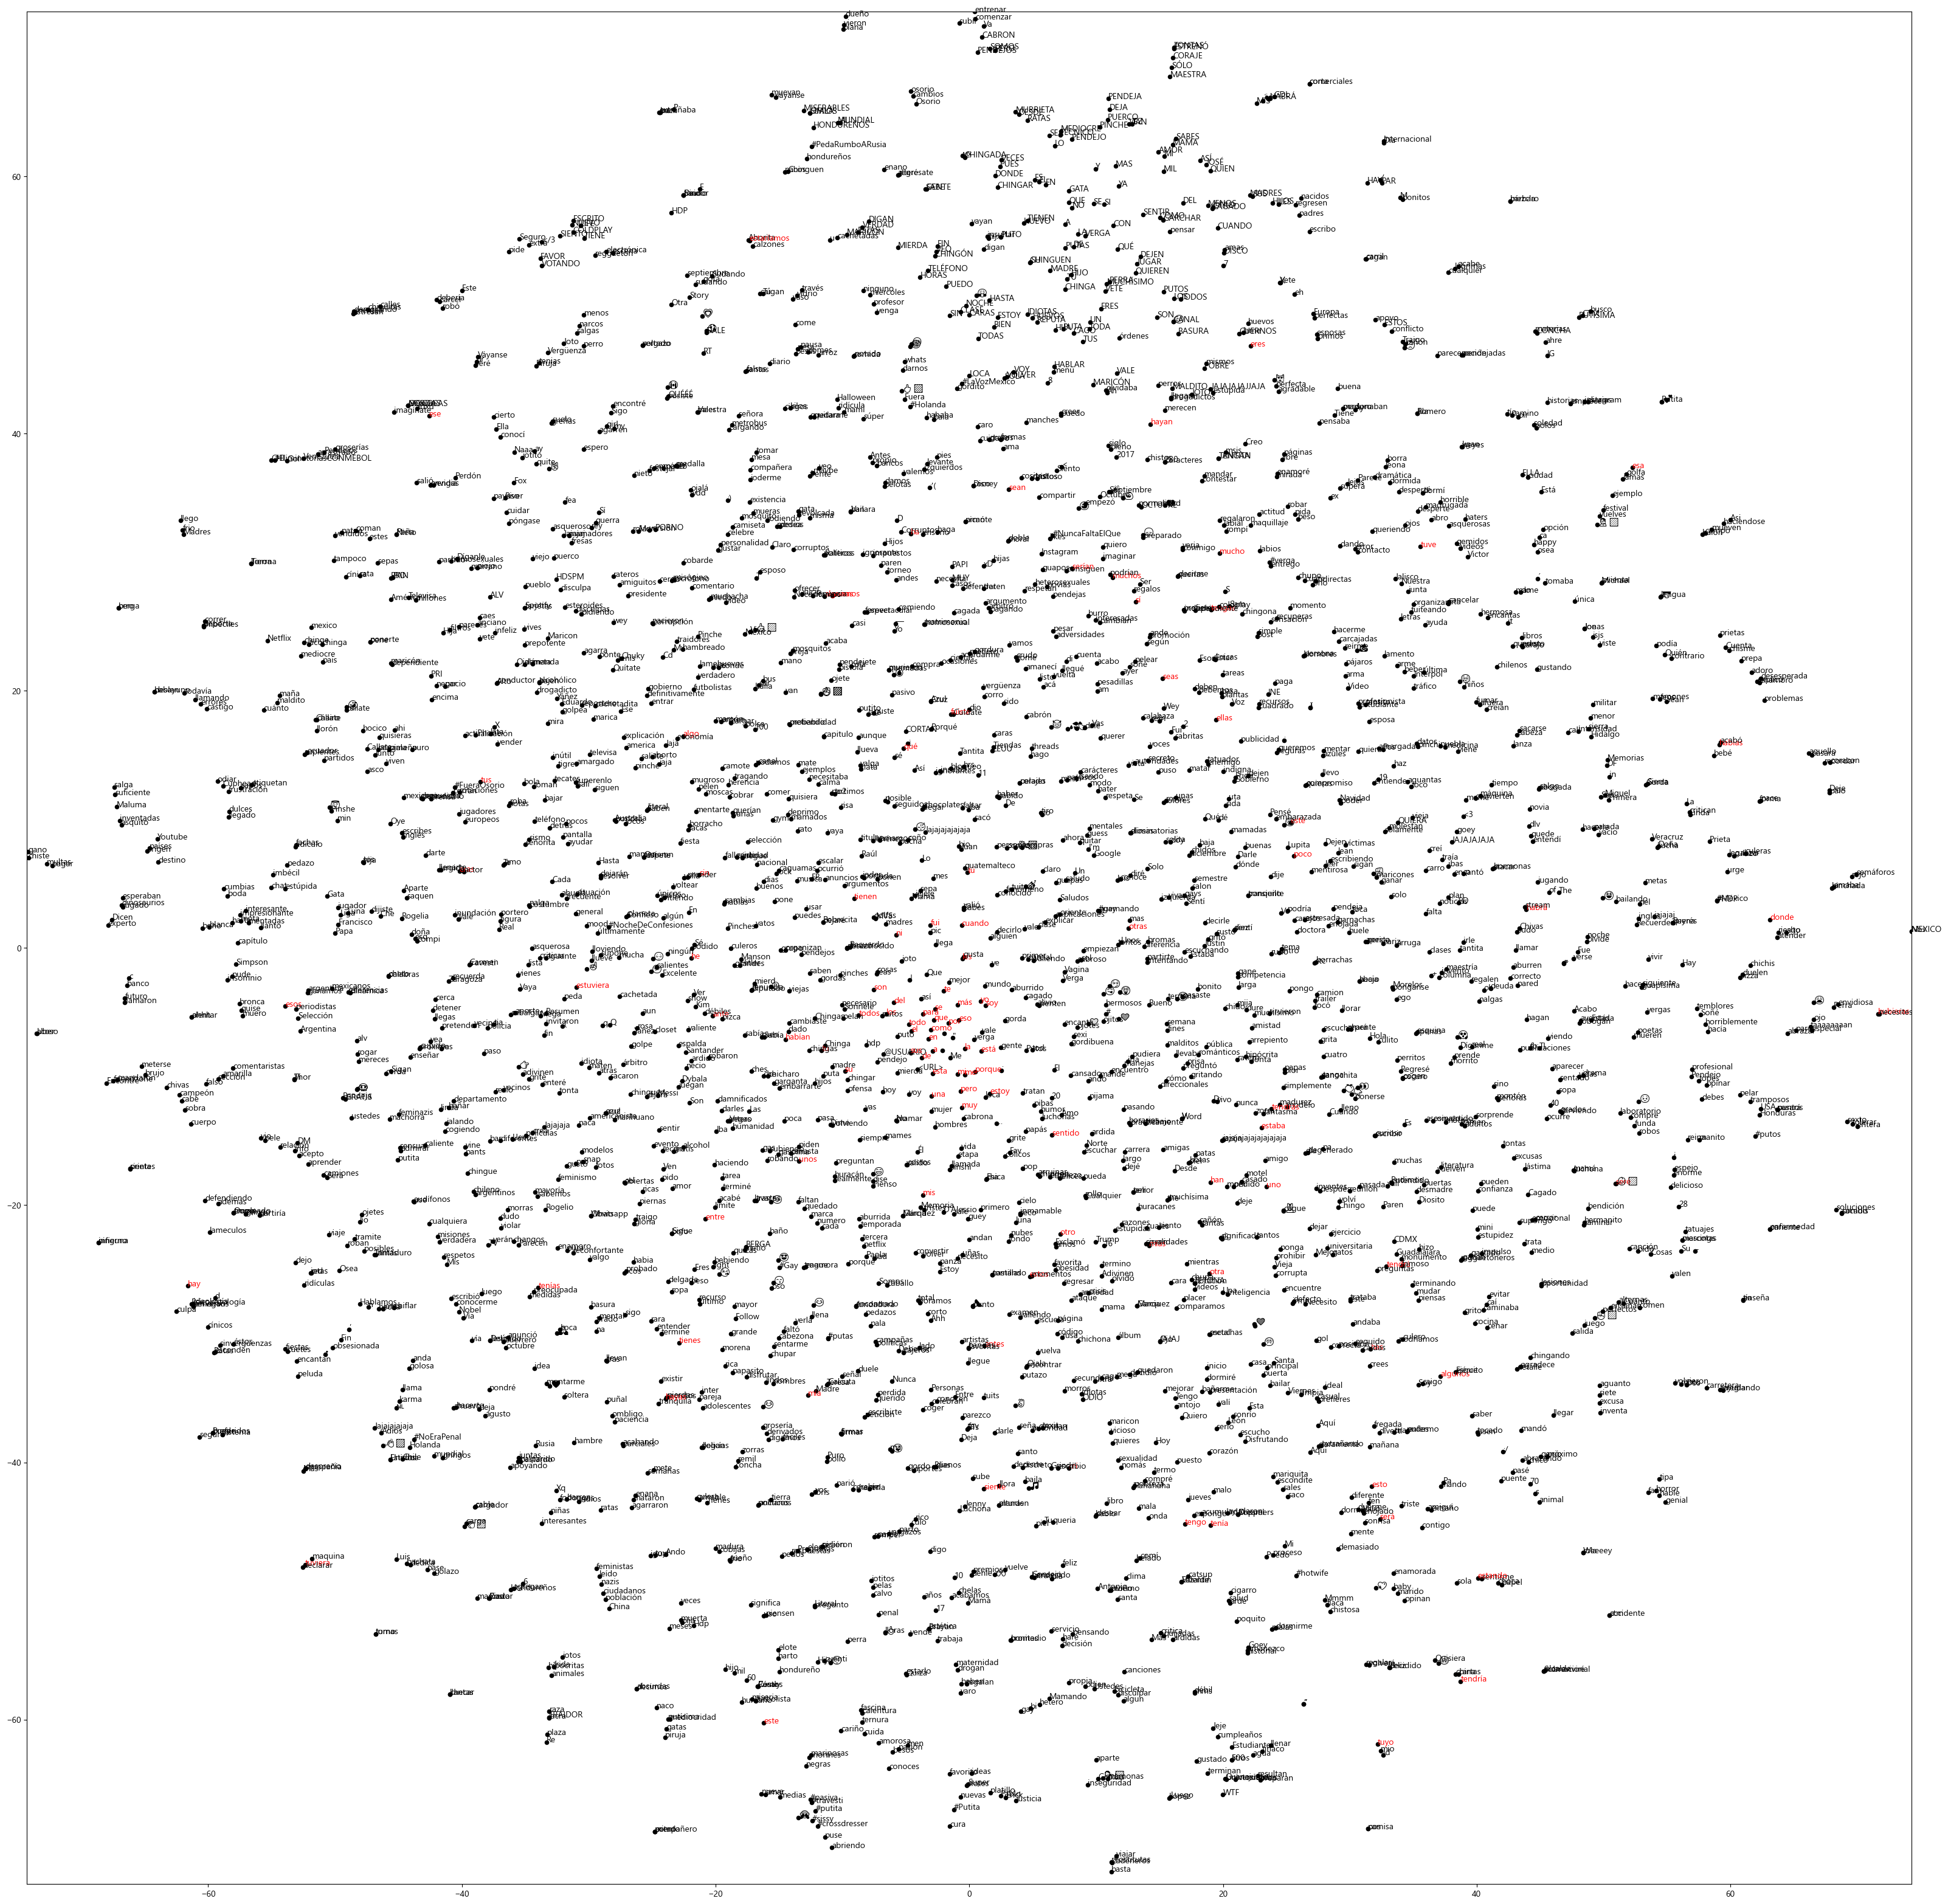

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Segoe UI Emoji'

plt.figure(figsize=(40,40), dpi = 100)
plt.xlim((-max_x,max_x))
plt.ylim((-max_y, max_y))
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], 20, color = "black")

for idx, word in enumerate(target_words):
    x = reduced_matrix[idx,0]
    y = reduced_matrix[idx,1]
    
    if word in sw:
        plt.annotate(word, (x,y), color = "red")
    else:
        plt.annotate(word, (x,y), color="black")

Una vez más, se puede observar que las stopwords suelen aglomerarse en una sección de la gráfica. Esta vez, no se ve un clúster tan definido para los insultos, sin embargo, aún se pueden encontrar juntos en la parte superior de la gráfica.

#### Gráfica de palabras con flechas

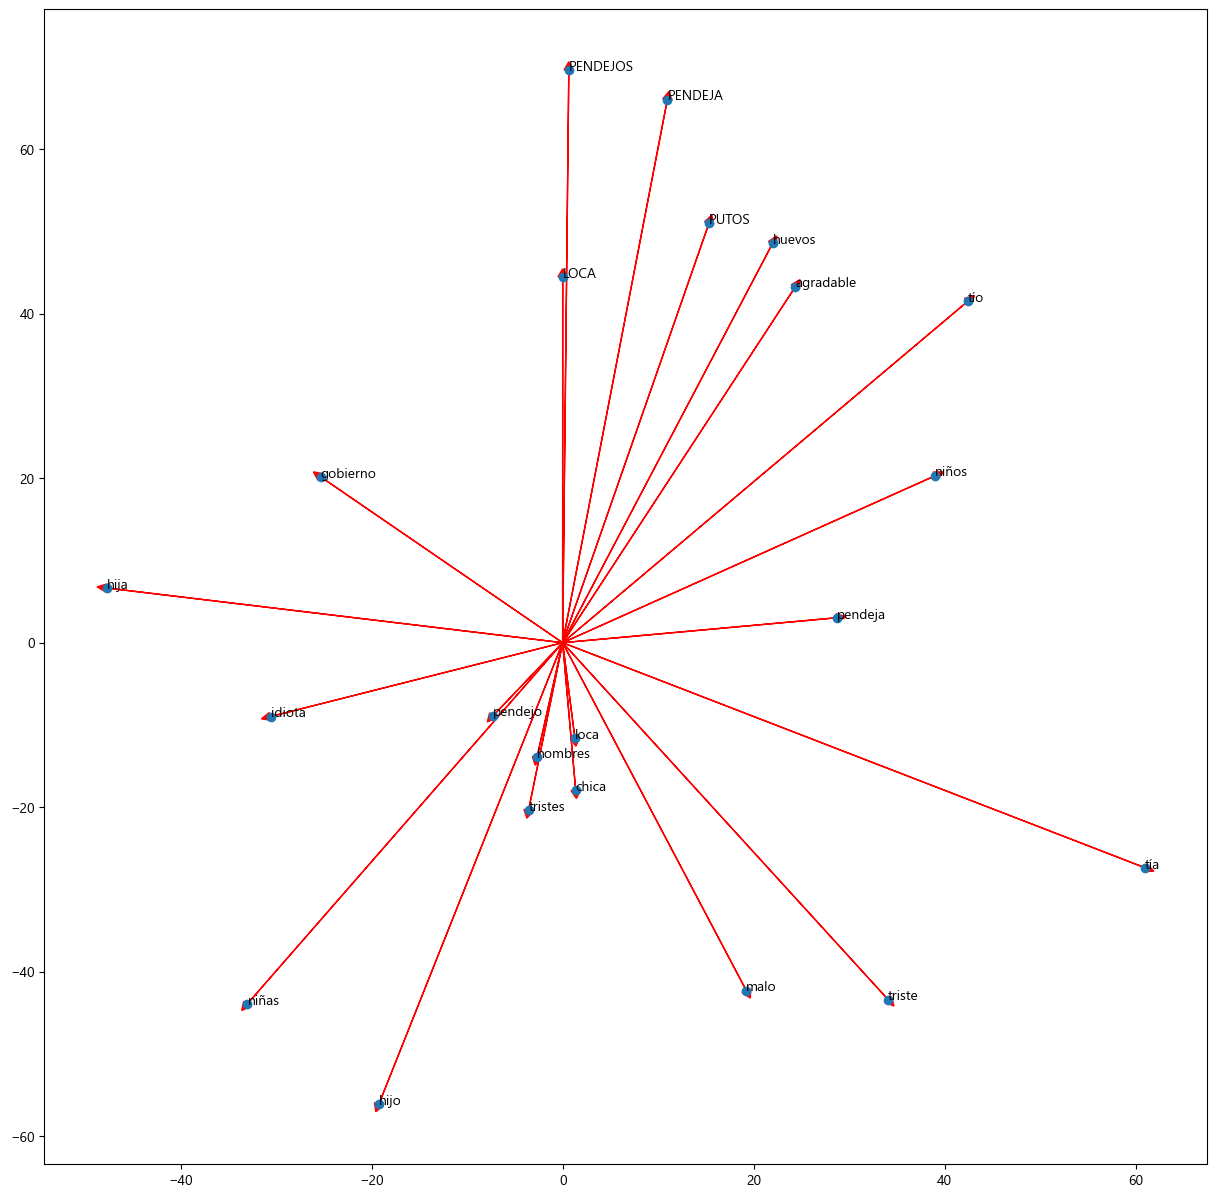

In [21]:
subset_words = ["tía", "tío", "idiota", "estúpido", "loca","tristes", "triste", "alegría", "pendejo", "pendeja", "chica", "hombres", "hija", "hijo"] +\
    ["flojo","gobierno","PUTOS", "PENDEJA", "LOCA","PENDEJOS","huevos", "bueno", "empático", "simpático", "agradable", "fútbol", "mujeres","hombres", "niños", "niñas", "malo", "horrendo", "desagradable", "psicópata", "tonto"] +\
    ["tristeza"]

plotted_subsetwords = []
subreduced_matrix = []

for idx, word in enumerate(target_words):
    if word in subset_words:
        plotted_subsetwords += [word]
        subreduced_matrix += [reduced_matrix[idx]]

subreduced_matrix = np.array(subreduced_matrix)
fig, ax = plt.subplots(figsize=(15,15))

col1 = 0
col2 = 1

for word in subreduced_matrix:
    ax.arrow(0,0, word[col1], word[col2], head_width = 1, head_length=1, fc = "r", ec = "r", width = 1e-2)

ax.scatter(subreduced_matrix[:,0], subreduced_matrix[:,1])

for i in range(0, len(plotted_subsetwords)):
    ax.annotate(plotted_subsetwords[i], (subreduced_matrix[i,0], subreduced_matrix[i,1]))
    
plt.show()

Vemos de nuevo los insultos algo aglomerados. La palabra `loca` ahora es colinear con `chica`, lo mismo también para `hombres` y `tristes`. `hijo` es casi perpendicular a `gobierno` y `tía`.

### Punto 3
Use alguna de las DTRs anteriores por separado de alguna forma para clasificación de 
documentos (e.g., promedio de vectores de términos en cada documento para representar). 
Compárelas contra un BoW-TFIDF de 5000 palabras más frecuentes.

#### Función para evaluar.

In [66]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score

def evaluar_bow(BOW_train, tr_y, BOW_test, val_y):
    # Parámetro de complejidad del SVM, se proponen estos
    # y se recorrerán con GridSearch
    parameters = {"C": [.05, .12, .25, .5, 1, 2, 4]}
    # Tratar de penalizar con base a la proporción de ejemplos
    # en cada clase
    svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
    grid = GridSearchCV(estimator=svr, param_grid=parameters,
                        n_jobs=6, scoring="f1_macro", cv=5)
    grid.fit(BOW_train, tr_y)
    y_pred = grid.predict(BOW_test)

    print(confusion_matrix(val_y, y_pred))
    print(metrics.classification_report(val_y, y_pred))
    print(f"F1-score: {f1_score(val_y, y_pred, pos_label='1'):.4f}")
    
    return grid

#### Primero recuperamos BOW-TFIDF y evaluamos

In [59]:
# Definimos BOW con esquema de peso de frecuencia.
def frecuencia_bow(tr_txt, V, dict_indices):
    BOW = np.zeros(shape=(len(tr_txt), len(V)), dtype=int)
    
    cont_doc = 0
    for tr in tr_txt:
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr))
        
        for word, freq in fdist_doc.items():
            if word in dict_indices:
                BOW[cont_doc, dict_indices[word]] = freq
        cont_doc += 1
    return BOW


# Definimos BOW con esquema de peso de tf-idf
def tfidf_bow(tr_txt, V, dict_indices):   
    # Un BOW de frecuencia nos ayuda a obtener tf
    # Lo haremos logaritmico
    f_bow = frecuencia_bow(tr_txt, V, dict_indices)
    tf = np.where(f_bow > 0, 1 + np.log10(f_bow),0)
    
    # De misma forma para df
    n_docs = len(tr_txt)
    df = np.count_nonzero(f_bow, axis=0)
    idf = np.log10(n_docs / (1+df))
    
    BOW = tf*idf

    return BOW

In [67]:
bow_tfidf_tr = tfidf_bow(tr_txt, V, dict_indices)
bow_tfidf_val = tfidf_bow(val_txt, V, dict_indices)
svr = evaluar_bow(bow_tfidf_tr, tr_y, bow_tfidf_val, val_y)

C:\Users\Gus\AppData\Local\Temp\ipykernel_24704\1664399021.py:21: RuntimeWarning: divide by zero encountered in log10
  tf = np.where(f_bow > 0, 1 + np.log10(f_bow),0)


[[365  53]
 [ 66 103]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       418
           1       0.66      0.61      0.63       169

    accuracy                           0.80       587
   macro avg       0.75      0.74      0.75       587
weighted avg       0.79      0.80      0.79       587

F1-score: 0.6338


#### Elegimos RI y lo evaluamos

Haremos que los documentos sean representados como la media de los vectores de términos que contienen.

In [ ]:
def RI_a_DR(tr_txt, RI):
    # Pasar de RI de vectores a una representacion de los documentos
    n_documentos = len(tr_txt)
    dimensiones = RI.shape[1]
    
    DR = np.zeros(shape=(n_documentos, dimensiones))
    
    for i in range(n_documentos):
        palabras = tokenizer.tokenize(tr_txt[i])
        cont_palabras = 0
        for palabra in palabras:
            if palabra in dict_indices:
                DR[i] += RI[dict_indices[palabra]]
                cont_palabras += 1
        
        if cont_palabras == 0:
            continue
        
        DR[i] /= cont_palabras
    
    return DR    

In [72]:
DR_tr = RI_a_DR(tr_txt, RI)
DR_tr.shape

(5278, 1000)

In [ ]:
# Hacemos el DR de validación con el mismo random indexing de cada término que se usó en el training
# No sé si sea mejor de otra forma.
DR_val = RI_a_DR(val_txt, RI)
DR_val.shape

(587, 1000)

Algo muy curioso que noté, es que, usando el Data Wrangler de VSCode, podemos ver que cada feature de la DR sigue una distribución marginal normal, consecuencia del TLC supongo.  

Ahora si, evaluamos

In [74]:
svr = evaluar_bow(DR_tr, tr_y, DR_val, val_y)

[[346  72]
 [ 46 123]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       418
           1       0.63      0.73      0.68       169

    accuracy                           0.80       587
   macro avg       0.76      0.78      0.77       587
weighted avg       0.81      0.80      0.80       587

F1-score: 0.6758


Vemos que obtenemos un F-score mayor al que obtuvimos utilizando una BoW-TFIDF!!!  
Se verifica entonces que el RI puede igualar o superar la BoW.

### Punto 4
Bajo la representación TCOR de los términos, y asumiendo un vocabulario de 5000 
palabras, muestre por orden de mayor similitud coseno (ver chp 6 del libro de Dan) los 
10 pares de palabras más parecidas en toda la colección.

In [77]:
# Ya tenemos un TCOR asumiendo un vocabulario de 5000 palabras.
TCOR.shape

(5000, 5000)

In [126]:
def compute_matrizSimilaridad(matriz):    
    n_vectores = matriz.shape[0]
    matriz_similaridad = np.zeros(shape=(n_vectores, n_vectores))
    for i in range(n_vectores-1):
        for j in range(i+1,n_vectores):
            if i != j:
                vector1 = matriz[i]
                vector2 = matriz[j]
                if np.linalg.norm(vector1) == 0 or np.linalg.norm(vector2) == 0:
                    continue
                matriz_similaridad[i,j] = np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    return matriz_similaridad

In [127]:
def encontrar_top_k(matriz_similaridad, k):
    top_k = dict()
    
    matriz = matriz_similaridad.copy()
    
    for _ in range(k):
        mayor = -np.inf
        for i in range(len(matriz)):
            for j in range(i+1, len(matriz)):
                if matriz[i,j] > mayor:
                    mayor = matriz[i,j]
                    indicei = i
                    indicej = j
        top_k[(indicei,indicej)] = float(matriz[indicei,indicej])
        matriz[indicei,indicej] = 0
    
    return top_k

In [128]:
matriz_similaridad = compute_matrizSimilaridad(TCOR)

top_10 = encontrar_top_k(matriz_similaridad, 10)

In [129]:
for (i, j), coseno in top_10.items():
    print(f"({dict_indice_invertido[i]},{dict_indice_invertido[j]}) : {matriz_similaridad[i,j]}")

(“,”) : 0.924008555474653
((,)) : 0.9168425286818008
(piercings,mascotas) : 0.8582905302582869
(simpatizantes,pedorros) : 0.84
(simpatizantes,opus) : 0.84
(simpatizantes,grupitos) : 0.84
(simpatizantes,coparmex) : 0.84
(pedorros,opus) : 0.84
(pedorros,grupitos) : 0.84
(pedorros,coparmex) : 0.84


Los dos primeros son muy obvios en cuánto a su relación, sin embargo, tengo dudas sobre los que le siguen: de qué forma o contexto podrían estar bien relacionadas las palabras `piercings` y `mascotas` ? Y qué hay de las palabras `simpatizantes`, `pedorros`, `opus`, `grupitos` y `coparmex`? Parece ser que todas entre sí tienen la misma medida de similaridad, supongo que es debido a que en el corpus solo unos cuantos documentos las contuvieron simultaneamente, aunque no estoy seguro.

### Punto 5
Bajo alguna representación de documentos hecha en esta tarea, y asumiendo un vocabulario de 5000 palabras, muestre por orden de más similitud coseno (ver chp 6 del libro de Dan) 10 pares de documentos más parecidos en toda la colección (no muestres pares de documentos que contengan exactamente substrings uno del otro; pues hay algo de redundancia en los datos). Muestre el texto que contienen y muestre la categoría de cada uno.

In [130]:
DR_tr.shape

(5278, 1000)

In [ ]:
# Podemos hacerlo sobre la DR 
matriz_similaridad = compute_matrizSimilaridad(DR_tr)


In [139]:
top_30 = encontrar_top_k(matriz_similaridad, 30)

In [171]:
# Definimos funciones para evitar los substrings
def son_textos_similares(texto1, texto2):
    s1 = texto1.strip().lower()
    s2 = texto2.strip().lower()
    return s1 in s2 or s2 in s1

def difieren_un_caracter(texto1, texto2):
    s1 = texto1.split()
    s2 = texto2.split()
    contador = 0
    for e1, e2 in zip(s1,s2):
        if e1 != e2:
            contador += 1
    
    return contador <= 1

In [170]:
contador = 0
for i, ((indicei, indicej), cosine) in enumerate(top_30.items()):
    if (not son_textos_similares(tr_txt[indicei], tr_txt[indicej])) and (not difieren_un_caracter(tr_txt[indicei], tr_txt[indicej])):
        print(f"----- Par {contador+1} -----")
        print(f"Coseno = {cosine:.3f}")
        print(f"Texto 1 - ¿Violento?: {tr_y[indicei]}\n",tr_txt[indicei])
        print(f"Texto 2 - ¿Violento?: {tr_y[indicej]}\n",tr_txt[indicej])
        contador += 1
        if contador >= 10:
            break

----- Par 1 -----
Coseno = 0.999
Texto 1 - ¿Violento?: 0
 Estúpidas, golfas, pirujas, ¡no tienen derechos!”, Zurita en MVS vs madres de familia | Homozapping"
Texto 2 - ¿Violento?: 0
 “¡Estúpidas, golfas, pirujas, ¡no tienen derechos!", arremete Zurita en MVS contra madres de familia
----- Par 2 -----
Coseno = 0.998
Texto 1 - ¿Violento?: 0
 Gio Dos Santos dejó bien ardida a Belinda.
Texto 2 - ¿Violento?: 0
 Belinda dejó bien ardido a Criss Angel.
----- Par 3 -----
Coseno = 0.996
Texto 1 - ¿Violento?: 0
 Luchaaaa!!! Lucha por tus metas!!! Se una chef luchona!!! Soy tu fan!!!
Texto 2 - ¿Violento?: 0
 Te pinches putas amoooooo!!! Que grande eres Leo!!!! El Dios del Fútbol Mundial!!!
----- Par 4 -----
Coseno = 0.996
Texto 1 - ¿Violento?: 1
 @USUARIO @USUARIO De parte mia chinga tu madre @USUARIO saludos
Texto 2 - ¿Violento?: 1
 @USUARIO @USUARIO @USUARIO @USUARIO Chinga tu madre pendejo
----- Par 5 -----
Coseno = 0.995
Texto 1 - ¿Violento?: 1
 Se le arrugó al maricon del chicharo!! Pecho f

Hay textos que se comparan porque están compartiendo la misma noticia (caso del par 1).
Otras razones es porque los textos comparten unas cuantas palabras, aunque estas en conjunto no comparten el mismo significado.
Los simbolos de puntuación (!,".:) también juegan un papel en la similaridad por el tokenizador que utilizamos. 4 de las 10 observaciones que mostré difieren en la categoría a la que pertenecen, así que los documentos pueden ser similares aún sin pertenecer a la misma categoría según esta muestra.